In [1]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


In [7]:
ifield=1
# PSF preparation
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   4
nx          =   nrot 
ny          =   1
ndata       =   nx*ny
scale       =   0.168
ngridTot    =   ngrid*nx
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']

np.random.seed(ifield*10000+1)
corPre='corPre'
ud          =   galsim.UniformDeviate(ifield*10000+1)
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)

# From noise power to noise correlation

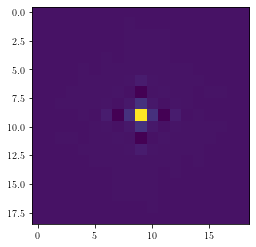

In [8]:
# Estimate Mean cor from noise
# power-> cor
corMea=np.zeros((ngrid,ngrid))
num=0
for i in range(1000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    corMea+=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(noi_array))**2.)).real
    num+=1
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corMea=corMea/corNum
corMea=corMea[ngrid//2-9:ngrid//2+10,ngrid//2-9:ngrid//2+10]/num
plt.imshow(corMea)

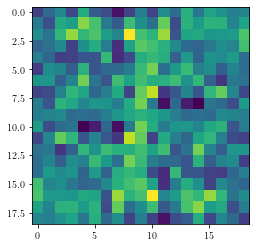

In [9]:
corIn=pyfits.getdata(corFname)*variance
corRes=corMea-corIn
plt.imshow(corRes)

# From noise power to noise correlation

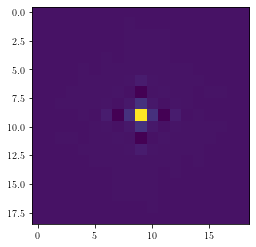

In [8]:
# Estimate Mean cor from noise
# power-> cor
corMea=np.zeros((ngrid,ngrid))
num=0
for i in range(1000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    powMea+=np.fft.fftshift(np.abs(np.fft.fft2(noi_array))**2.)
    num+=1
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corMea=corMea/corNum
corMea=corMea[ngrid//2-9:ngrid//2+10,ngrid//2-9:ngrid//2+10]/num
plt.imshow(corMea)

In [11]:
corIn.shape

(19, 19)

In [12]:
psfImg.array.shape

(43, 43)

In [10]:
corIn=pyfits.getdata(corFname)*variance

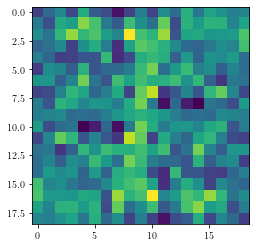

In [9]:
corRes=corMea-corIn
plt.imshow(corRes)